In [90]:
# ! pip install chembl_webresource_client numpy pandas seaborn wget
# conda install -c rdkit rdkit -y
# ! conda install -c conda-forge wget

In [91]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from chembl_webresource_client.new_client import new_client
from rdkit.Chem import Lipinski, Descriptors
from rdkit import Chem
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import r2_score, mean_squared_error
import lazypredict
from collections import Counter
from lazypredict.Supervised import LazyRegressor
import  os

In [92]:
def model_scoring(y_test, y_pred):
    """ Calculates the statistics necessary to score a ML models performance
    
    Parameters:
    ***********
    y_test : PD_array
    y_pred : PD_array
    
    Returns: 
    *********
    Statistics : Array of values coorisponding to MSE, R2, ASE"""

    from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

    MSE = mean_squared_error(y_test, y_pred)
    R2 = r2_score(y_test, y_pred)
    MAE = mean_absolute_error(y_test, y_pred)

    Statistics = [{'MSE' : MSE}, {'R2' : R2}, {'MAE' : MAE}]

    return Statistics

In [93]:
# compute the Lipinski descriptors
def lipinski(smiles, verbose=False):
    
    moldata=[]
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem)
        moldata.append(mol)
    
    baseData = []
    i=0
    for mol in moldata:
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
    
        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHAcceptors,
                        desc_NumHDonors])
        
        if (i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1
    columnNames=["MW", "LogP", "NumDonors", "NumAcceptors"]
    descriptors = pd.DataFrame(data=baseData, columns=columnNames)

    return descriptors


In [94]:
def pIC50(input):
    pIC50 = []

    for i in input['standard_value_norm']:
        molar = i*(10**-9)
        pIC50.append(-np.log10(molar))
    input['pIC50'] = pIC50
    x = input.drop('standard_value_norm', axis=1)

    return x

In [95]:
def norm_value(input):
    norm = []

    for i in input['standard_value']:
        if i > 100000000:
            i = 100000000
        norm.append(i)
    input['standard_value_norm'] = norm
    x = input.drop('standard_value', axis=1)

    return x

In [96]:
# Target search
target = new_client.target
# query = input('Target query:')
query = 'Acetylcholinesterase'
target_query = target.search(query)
targets = pd.DataFrame.from_dict(target_query)
print(targets)
# selected_target = targets.target_chembl_id[int(input('Select Target Index:)'))]
selected_target = targets.target_chembl_id[0]
# print(selected_target)

                                     cross_references  \
0   [{'xref_id': 'P22303', 'xref_name': None, 'xre...   
1                                                  []   
2                                                  []   
3                                                  []   
4                                                  []   
5   [{'xref_id': 'P04058', 'xref_name': None, 'xre...   
6   [{'xref_id': 'P21836', 'xref_name': None, 'xre...   
7   [{'xref_id': 'P37136', 'xref_name': None, 'xre...   
8   [{'xref_id': 'O42275', 'xref_name': None, 'xre...   
9   [{'xref_id': 'P23795', 'xref_name': None, 'xre...   
10                                                 []   
11                                                 []   
12                                                 []   
13                                                 []   
14                                                 []   
15  [{'xref_id': 'Q95P20', 'xref_name': None, 'xre...   
16                             

In [97]:
# Select target protein
activity = new_client.activity
res = activity.filter(target_chembl_id=selected_target).filter(standard_type='IC50')
df = pd.DataFrame.from_dict(res)
# print(df)

In [98]:
# create new directory to save files for user per search
# Note:  May need to add a condition here so that if a similar search query is used it doesn't overwrite the previous query results. 
current_directory = os.getcwd()
new_folder = os.path.join(current_directory, f'{query}_{selected_target}_drug_discovery')

# Create the folder
try:
    os.makedirs(new_folder)
    print(f"Folder '{new_folder}' created successfully.")
except FileExistsError:
    print(f"Folder '{new_folder}' already exists.")
except Exception as e:
    print(f"An error occurred: {e}")

Folder '/Users/loganwallace/Python_Projects/Bioinformatics/Drug_Discovery/Acetylcholinesterase_CHEMBL220_drug_discovery' already exists.


In [99]:
df.to_csv(os.path.join(new_folder, f'{query}_01_Bioactivity_data.csv'), index=False)

In [100]:
# process data and get rid of missing values in dataset
df2 = pd.read_csv(os.path.join(new_folder, f'{query}_01_Bioactivity_data.csv'))
df2 = df2[df2.standard_value.notna()]
# print(df2.isna().sum())

*** Bioactivity classes are given to the data to give us information on whether a drug will be active, inactive or an intermediate. Drugs that are inactive will have a standard_value of greater than 10,000. Drugs that have a standard value of less than 1000 are considered active and anything inbetween 1000 and 10,000 is considered to be an intermediate. ***

In [101]:

# create a bioactivty class column
bioactivity_class = []
for i in df2.standard_value:
    if float(i) >= 10000:
        bioactivity_class.append("inactive")
    elif float(i) <= 1000:
        bioactivity_class.append("active")
    else:
        bioactivity_class.append("intermediate")

# Make a compressed dataset with just the values we would like for our analysis
select = ['molecule_chembl_id', 'canonical_smiles', 'standard_value']
df3 = df2[select].reset_index(drop=True)


df4 = pd.concat([df3, pd.DataFrame(bioactivity_class)], axis=1).dropna(subset=['canonical_smiles']).rename(columns = {0:'bioactivity_class'})
df4 = df4[df4['standard_value'] != 0].reset_index(drop=True)
# print(df4.isna().sum())


In [102]:
#Export preprocessed data to csv
df4.to_csv(os.path.join(new_folder, f'{query}_02_bioactivity_data_preprocessed.csv'), index=False)


**Lipinski Descriptors/ Rule of 5:**
- Molecular weight < 500 Daltons
- Octanol-water partition coefficient (Log P) < 5
- Hydrogen bond donors < 5
- Hydrogen bond acceptors < 10

**This rule governs these aspects of drug likeness of compounds and pharmocokinetic properties (ADME):**
- Absorbtion
- Distribution
- Metabolism
- Excretion

In [103]:
df_lipinski = lipinski(df4.canonical_smiles).reset_index(drop=True)

In [104]:
# combine both data sets to make a complete dataset for analysis
df_combined = pd.concat([df4, df_lipinski], axis=1)
# print(df_combined)

In [105]:
# calculate the pIC50 value utilizing the functions above
# df_final = pIC50(norm_value(df_combined))
df_norm = norm_value(df_combined)
df_final = pIC50(df_norm)
print(df_final.columns)
# print(df_norm.isna().sum(), df_norm.describe())
# print(df_final.isna().sum())


Index(['molecule_chembl_id', 'canonical_smiles', 'bioactivity_class', 'MW',
       'LogP', 'NumDonors', 'NumAcceptors', 'pIC50'],
      dtype='object')


In [106]:
df_final.to_csv(os.path.join(new_folder,f'{query}_03_bioactivity_data_final_pIC50.csv'), index=False)

The next section conducts some exploratory data analysis utilizing the bioactivity classes we assigned earlier. We will focus on **'Active'** and **'Inactive'** compounds in our data set.

In [107]:
df_2_class = df_final[df_final['bioactivity_class'] != 'intermediate']
df_2_class.to_csv(os.path.join(new_folder, f'{query}_04_bioactivity_data_2class.csv'), index=False)
# print(df_2_class)

In [108]:
def mannwhitney(descriptor, verbose=False):
    from numpy.random import seed
    from numpy.random import randn
    from scipy.stats import mannwhitneyu

    seed(1)

    selection = [descriptor, 'bioactivity_class']
    df = df_2_class[selection]
    active = df[df['bioactivity_class'] == 'active']
    active = active[descriptor]

    selection = [descriptor, 'bioactivity_class']
    df = df_2_class[selection]
    inactive = df[df['bioactivity_class'] == 'inactive']
    inactive = inactive[descriptor]

    stat, p = mannwhitneyu(active, inactive)
    print('Statistics=%.3f, p=%.3f' % (stat, p))

    alpha = 0.05
    if p > alpha:
        interpretation = 'Same distrubution (fail to reject H0)'
    else:
        interpretation = 'Different distrubution (reject H0)'
    
    results = pd.DataFrame({'Descriptor':descriptor, 
                            'Statistics':stat,
                            'p':p,
                            'alpha':alpha,
                            'Interpretation':interpretation}, index=[0])
    filename = f'mannwhitneyu_{descriptor}.csv'
    results.to_csv(os.path.join(new_folder, filename))
    return results



In [109]:
sns.set_palette('deep')
sns.set_style("ticks")

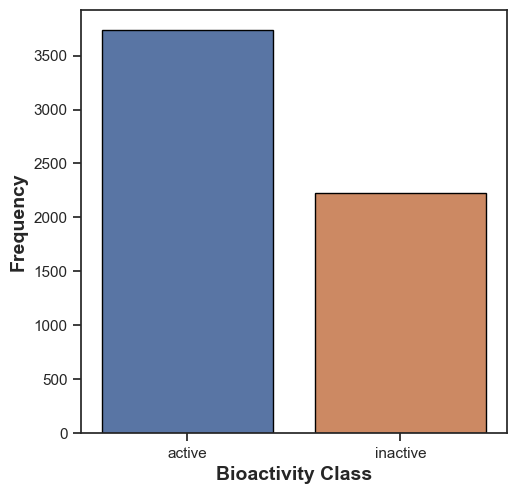

<Figure size 640x480 with 0 Axes>

In [110]:
plt.figure(figsize=(5.5,5.5))
sns.countplot(x='bioactivity_class', data=df_2_class, edgecolor='black', hue='bioactivity_class')
plt.xlabel('Bioactivity Class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')
plt.show()
plt.savefig(os.path.join(new_folder, f'{query}_plot_bioactivity_class.pdf'))

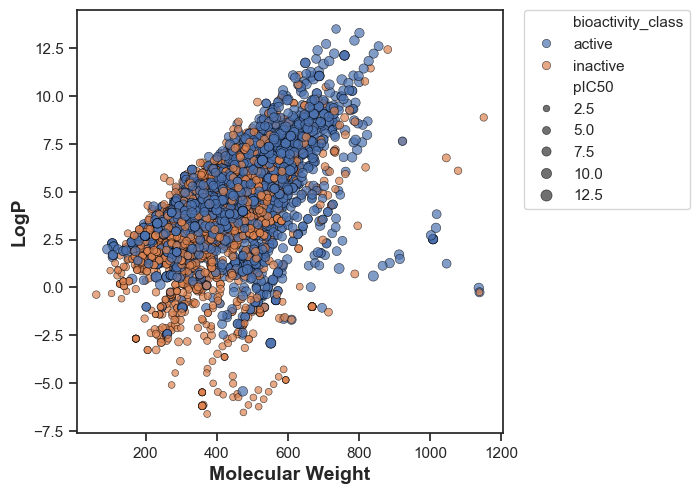

<Figure size 640x480 with 0 Axes>

In [111]:
# split data set into X and y for graphical analysis. We now have 2 classes which we can analyze against eachother. 
plt.figure(figsize=(5.5,5.5))
sns.scatterplot(x='MW', y='LogP', size='pIC50', data=df_2_class, edgecolor='black', hue='bioactivity_class', alpha=0.7)
plt.xlabel('Molecular Weight', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.show()
plt.savefig(os.path.join(new_folder, f'{query}_plot_MW_vs_LogP.pdf'))

Statistics=4772649.000, p=0.000
0   0.00
Name: p, dtype: float64


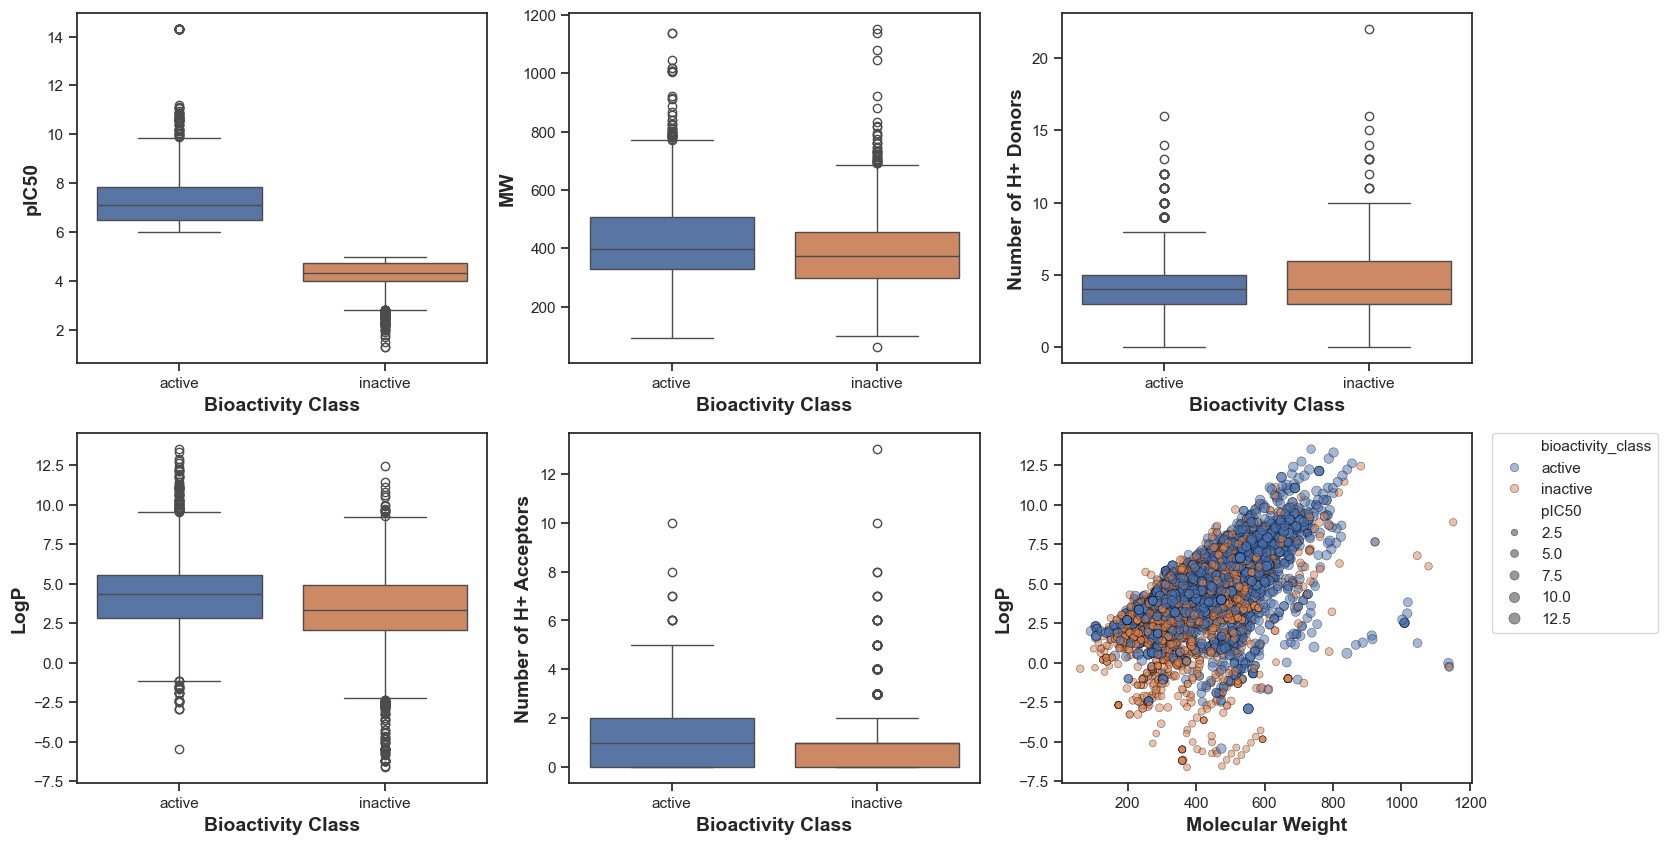

In [112]:
p_value = mannwhitney('MW')['p']
print(p_value)
fig, axs = plt.subplots(2,3, figsize=(18,10))
sns.boxplot(x='bioactivity_class', y='pIC50', data=df_2_class, hue='bioactivity_class', ax= axs[0,0])
axs[0,0].set_xlabel('Bioactivity Class', fontsize=14, fontweight='bold')
axs[0,0].set_ylabel('pIC50', fontsize=14, fontweight='bold')
# axs[0,0].text(0.05, 0.95, f'MSE = {p_value:.2f}', 
#             transform=axs[0].transAxes, fontsize=12, verticalalignment='top',
#             bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))

sns.boxplot(x='bioactivity_class', y='MW', data=df_2_class, hue='bioactivity_class', ax=axs[0,1])
axs[0,1].set_xlabel('Bioactivity Class', fontsize=14, fontweight='bold')
axs[0,1].set_ylabel('MW', fontsize=14, fontweight='bold')

sns.boxplot(x='bioactivity_class', y='LogP', data=df_2_class, hue='bioactivity_class', ax=axs[1,0])
axs[1,0].set_xlabel('Bioactivity Class', fontsize=14, fontweight='bold')
axs[1,0].set_ylabel('LogP', fontsize=14, fontweight='bold')

sns.boxplot(x='bioactivity_class', y='NumAcceptors', data=df_2_class, hue='bioactivity_class', ax=axs[1,1])
axs[1,1].set_xlabel('Bioactivity Class', fontsize=14, fontweight='bold')
axs[1,1].set_ylabel('Number of H+ Acceptors', fontsize=14, fontweight='bold')

sns.boxplot(x='bioactivity_class', y='NumDonors', data=df_2_class, hue='bioactivity_class', ax=axs[0,2])
axs[0,2].set_xlabel('Bioactivity Class', fontsize=14, fontweight='bold')
axs[0,2].set_ylabel('Number of H+ Donors', fontsize=14, fontweight='bold')

sns.scatterplot(x='MW', y='LogP', size='pIC50', data=df_2_class, edgecolor='black', hue='bioactivity_class', alpha=0.5, ax=axs[1,2])
axs[1,2].set_xlabel('Molecular Weight', fontsize=14, fontweight='bold')
axs[1,2].set_ylabel('LogP', fontsize=14, fontweight='bold')
axs[1,2].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)




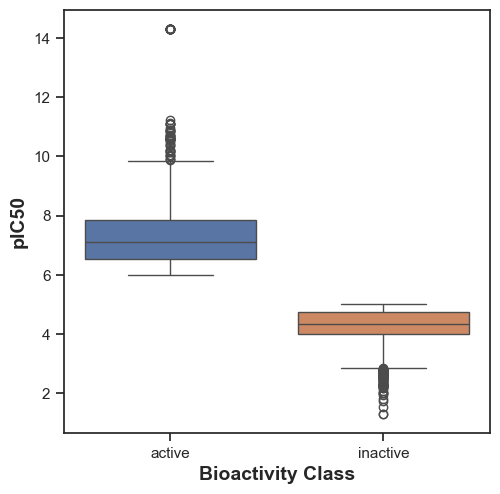

Statistics=8317050.000, p=0.000


,Descriptor,Statistics,p,alpha,Interpretation
0,pIC50,8317050.00,0.00,0.05,Different distrubution (reject H0)


<Figure size 640x480 with 0 Axes>

In [113]:
plt.figure(figsize=(5.5,5.5))
sns.boxplot(x='bioactivity_class', y='pIC50', data=df_2_class, hue='bioactivity_class')
plt.xlabel('Bioactivity Class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50', fontsize=14, fontweight='bold')
plt.show()
plt.savefig(os.path.join(new_folder, f'{query}_plot_pIC50.pdf'))
mannwhitney('pIC50')

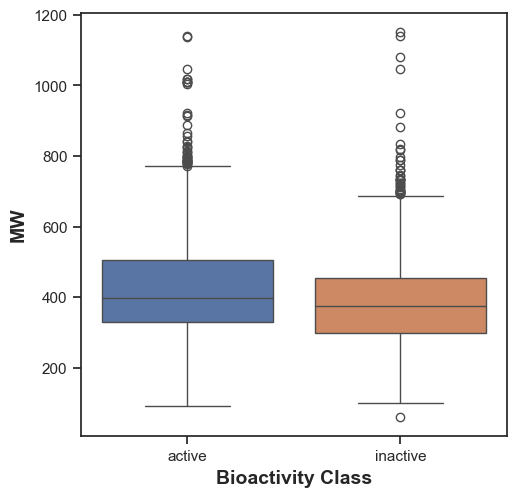

Statistics=4772649.000, p=0.000


,Descriptor,Statistics,p,alpha,Interpretation
0,MW,4772649.00,0.00,0.05,Different distrubution (reject H0)


<Figure size 640x480 with 0 Axes>

In [114]:
plt.figure(figsize=(5.5,5.5))
sns.boxplot(x='bioactivity_class', y='MW', data=df_2_class, hue='bioactivity_class')
plt.xlabel('Bioactivity Class', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')
plt.show()
plt.savefig(os.path.join(new_folder, f'{query}_plot_MW.pdf'))

mannwhitney('MW')

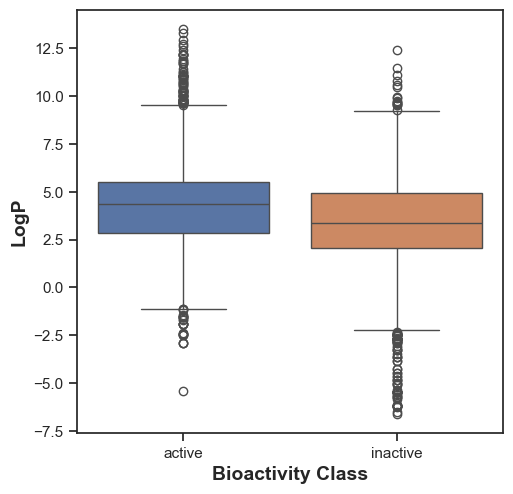

Statistics=5163689.500, p=0.000


,Descriptor,Statistics,p,alpha,Interpretation
0,LogP,5163689.50,0.00,0.05,Different distrubution (reject H0)


<Figure size 640x480 with 0 Axes>

In [115]:
plt.figure(figsize=(5.5,5.5))
sns.boxplot(x='bioactivity_class', y='LogP', data=df_2_class, hue='bioactivity_class')
plt.xlabel('Bioactivity Class', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.show()
plt.savefig(os.path.join(new_folder, f'{query}_plot_LogP.pdf'))
mannwhitney('LogP')

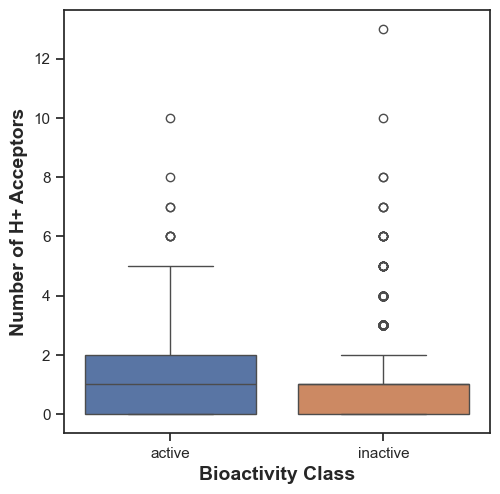

Statistics=4504594.000, p=0.000


,Descriptor,Statistics,p,alpha,Interpretation
0,NumAcceptors,4504594.00,0.00,0.05,Different distrubution (reject H0)


<Figure size 640x480 with 0 Axes>

In [116]:
plt.figure(figsize=(5.5,5.5))
sns.boxplot(x='bioactivity_class', y='NumAcceptors', data=df_2_class, hue='bioactivity_class')
plt.xlabel('Bioactivity Class', fontsize=14, fontweight='bold')
plt.ylabel('Number of H+ Acceptors', fontsize=14, fontweight='bold')
plt.show()
plt.savefig(os.path.join(new_folder, f'{query}_plot_NumHAcceptors.pdf'))
mannwhitney('NumAcceptors')

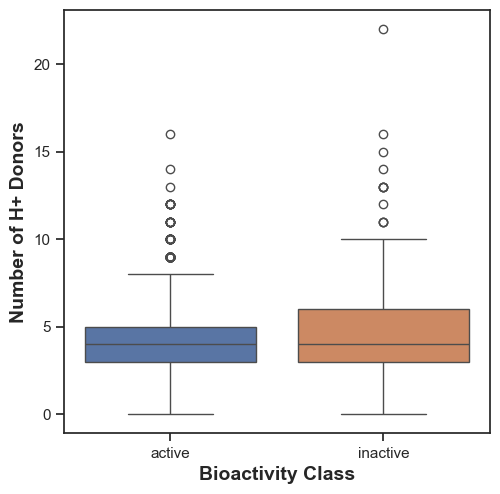

Statistics=4172961.000, p=0.820


,Descriptor,Statistics,p,alpha,Interpretation
0,NumDonors,4172961.00,0.82,0.05,Same distrubution (fail to reject H0)


<Figure size 640x480 with 0 Axes>

In [117]:
plt.figure(figsize=(5.5,5.5))
sns.boxplot(x='bioactivity_class', y='NumDonors', data=df_2_class, hue='bioactivity_class')
plt.xlabel('Bioactivity Class', fontsize=14, fontweight='bold')
plt.ylabel('Number of H+ Donors', fontsize=14, fontweight='bold')
plt.show()
plt.savefig(os.path.join(new_folder, f'{query}_plot_NumDonors.pdf'))
mannwhitney('NumDonors')

This next section calculates molecular descriptors to train a ML model to predict the pIC50 value of any given drug given its molecular fingerpring.
To do this we will feed a RandomForest ML algorithm pIC50 values and fingerprint data and measure how well the model performs. 
Graphing predicted vs actual is a good way to measure the accuracy of the model using the coorelation coefficent R^2. 
We can also use a package to analyze multiple different models to figure out which one would be the best for our dataset, which we do in the next seciton. 

In [118]:
# Import PaDEL descriptor program zip file
# ! wget http://www.yapcwsoft.com/dd/padeldescriptor/PaDEL-Descriptor.zip
# ! mkdir -p ./PaDEL-Descriptor
# ! unzip PaDEL-Descriptor.zip -d ./PaDEL-Descriptor


In [119]:
#  Make a folder and unzip the PaDEL-Descriptor.zip file 
# ! mkdir -p ./PaDEL-Descriptor
# ! unzip PaDEL-Descriptor.zip -d ./PaDEL-Descriptor


In [120]:
# Create a file with data needed to generate a molecular fingerprint by the PaDEL software
selection = ['canonical_smiles', 'molecule_chembl_id']
df_selection = df_final[selection]
df_selection.to_csv(os.path.join(new_folder, f'{query}_{selected_target}_molecule.smi'), sep='\t', \
                    index=False, header=False)

In [121]:
# Export path directory to .txt document to be read in by our BASH file which will run the PaDEL program
with open(os.path.join('./PaDEL-Descriptor', 'output_dir.txt'), 'w') as f:
    f.write(new_folder)

In [122]:
! Bash ./PaDEL-Descriptor/padel.sh
### may be able to explore the subprocess package to run bash scripting in the python program. \
# This will help move this program away from jupyter notebooks in the future. 

Processing CHEMBL133897 in Acetylcholinesterase_CHEMBL220_molecule.smi (1/7805). 
Processing CHEMBL336398 in Acetylcholinesterase_CHEMBL220_molecule.smi (2/7805). 
Processing CHEMBL131588 in Acetylcholinesterase_CHEMBL220_molecule.smi (3/7805). 
Processing CHEMBL130628 in Acetylcholinesterase_CHEMBL220_molecule.smi (4/7805). 
Processing CHEMBL130478 in Acetylcholinesterase_CHEMBL220_molecule.smi (5/7805). 
Processing CHEMBL130112 in Acetylcholinesterase_CHEMBL220_molecule.smi (6/7805). 
Processing CHEMBL130098 in Acetylcholinesterase_CHEMBL220_molecule.smi (7/7805). 
Processing CHEMBL337486 in Acetylcholinesterase_CHEMBL220_molecule.smi (8/7805). 
Processing CHEMBL131051 in Acetylcholinesterase_CHEMBL220_molecule.smi (10/7805). Average speed: 2.29 s/mol.
Processing CHEMBL336538 in Acetylcholinesterase_CHEMBL220_molecule.smi (9/7805). Average speed: 4.44 s/mol.
Processing CHEMBL341437 in Acetylcholinesterase_CHEMBL220_molecule.smi (11/7805). Average speed: 1.56 s/mol.
Processing CHEMBL3

** TRAINING OUR MODEL **

In [123]:
# Import the generated fingerprints for all compounds in our data
df_descriptors = pd.read_csv(os.path.join(new_folder, 'descriptors_output.csv'))
# print(df_descriptors.columns)

In [124]:
# Train the Model

df_X = df_descriptors.drop(columns='Name')
print(df_X.shape)
df_y = df_final['pIC50']
print(df_y.shape)

random = 42

# Review this portion for understanding removal of low variance features
selection = VarianceThreshold(threshold=(.8 * (1-.8)))
X = selection.fit_transform(df_X)
# print(df_y.shape, X.shape)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, df_y, test_size=0.2, random_state=random)
# print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

#Establish model and train it
model = RandomForestRegressor(n_estimators=100, random_state=random)
model_train = model.fit(X_train, y_train)
Y_pred = model.predict(X_test)
# print(Y_pred.shape)



(7805, 881)
(7805,)


In [125]:
# Lets establish a different model that performed better in our model analysis:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
model2 = GradientBoostingRegressor(random_state=random, n_estimators=100)
model2.fit(X_train, y_train)
y2_pred = model2.predict(X_test)

MSE2 = mean_squared_error(y_test, y2_pred)
r22 = r2_score(y_test, y2_pred)
print(f"MSE: {MSE2:.2f}, R2: {r22:.2f}")


MSE: 1.76, R2: 0.26


In [126]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

model3 = DecisionTreeRegressor(random_state=random)
model3.fit(X_train, y_train)
y3_pred = model3.predict(X_test)
MSE3 = mean_squared_error(y_test, y3_pred)
r23 = r2_score(y_test, y3_pred)
print(f"MSE: {MSE3:.2f}, R2: {r23:.2f}")


MSE: 2.04, R2: 0.14


In [127]:
# How well did the model perform:
MSE = float(mean_squared_error(y_test, Y_pred))
r2 = float(r2_score(y_test, Y_pred))
print(f"MSE: {MSE:.2f}, R2: {r2:.2f}")

MSE: 1.56, R2: 0.35


Text(0.05, 0.95, 'MSE = 2.04\nR2 = 0.14')

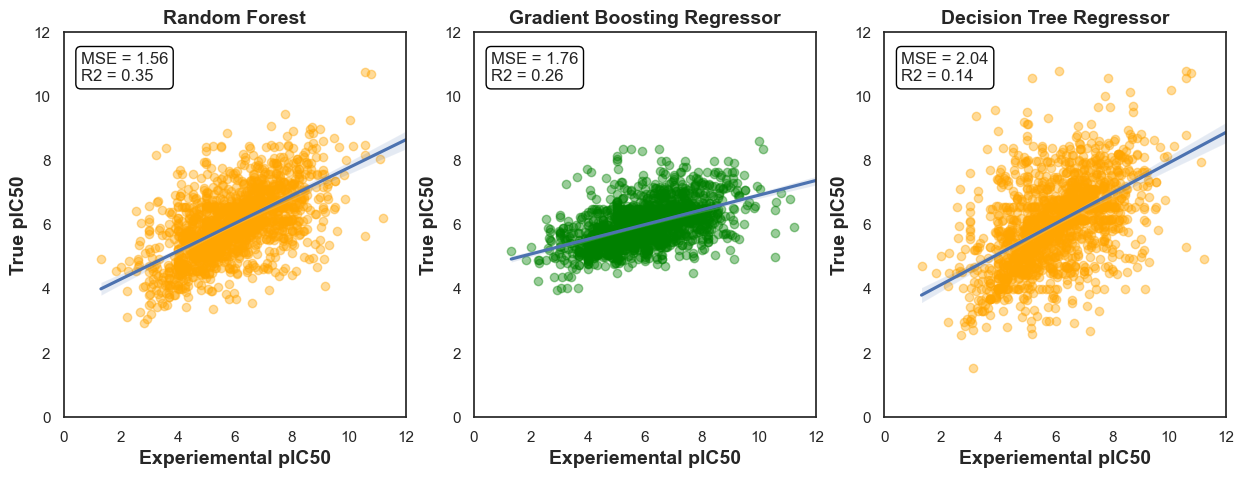

In [128]:
# Create visual of true values vs predicted values to visualize linear coorilation. 
sns.set(color_codes=True)
sns.set_style('white')

fig, axs = plt.subplots(1,3,figsize=(15,5))
sns.regplot(x=y_test, y=Y_pred,ax=axs[0], scatter_kws={'alpha':0.4, 'color':'orange'})
axs[0].set_title('Random Forest', fontsize=14, fontweight='bold')
axs[0].set_xlabel('Experiemental pIC50', fontsize=14, fontweight='bold')
axs[0].set_ylabel('True pIC50', fontsize=14, fontweight='bold')
axs[0].set_xlim(0, 12)
axs[0].set_ylim(0, 12)
axs[0].text(0.05, 0.95, f'MSE = {MSE:.2f}\nR2 = {r2:.2f}', 
            transform=axs[0].transAxes, fontsize=12, verticalalignment='top',
            bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))

sns.regplot(x=y_test, y=y2_pred, ax=axs[1], scatter_kws={'alpha':0.4, 'color':'green'})
axs[1].set_title('Gradient Boosting Regressor', fontsize=14, fontweight='bold')
axs[1].set_xlabel('Experiemental pIC50', fontsize=14, fontweight='bold')
axs[1].set_ylabel('True pIC50', fontsize=14, fontweight='bold')
axs[1].set_xlim(0, 12)
axs[1].set_ylim(0, 12)
axs[1].text(0.05, 0.95, f'MSE = {MSE2:.2f}\nR2 = {r22:.2f}', 
            transform=axs[1].transAxes, fontsize=12, verticalalignment='top',
            bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))

sns.regplot(x=y_test, y=y3_pred,ax=axs[2], scatter_kws={'alpha':0.4, 'color':'orange'})
axs[2].set_title('Decision Tree Regressor', fontsize=14, fontweight='bold')
axs[2].set_xlabel('Experiemental pIC50', fontsize=14, fontweight='bold')
axs[2].set_ylabel('True pIC50', fontsize=14, fontweight='bold')
axs[2].set_xlim(0, 12)
axs[2].set_ylim(0, 12)
axs[2].text(0.05, 0.95, f'MSE = {MSE3:.2f}\nR2 = {r23:.2f}', 
            transform=axs[2].transAxes, fontsize=12, verticalalignment='top',
            bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))

In [129]:
# ! pip install lazypredict


In [130]:
clf = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
train, test = clf.fit(X_train, X_test, y_train, y_test)
print(train)
print(test)

 98%|█████████▊| 41/42 [00:48<00:00,  1.08it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005813 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 6244, number of used features: 137
[LightGBM] [Info] Start training from score 6.000877


100%|██████████| 42/42 [00:49<00:00,  1.18s/it]

                                       Adjusted R-Squared  \
Model                                                       
HistGradientBoostingRegressor                        0.31   
LGBMRegressor                                        0.30   
RandomForestRegressor                                0.28   
XGBRegressor                                         0.28   
SVR                                                  0.27   
NuSVR                                                0.27   
BaggingRegressor                                     0.26   
KNeighborsRegressor                                  0.24   
MLPRegressor                                         0.22   
GradientBoostingRegressor                            0.19   
LassoCV                                              0.12   
RidgeCV                                              0.12   
ElasticNetCV                                         0.12   
Ridge                                                0.12   
TransformedTargetRegress

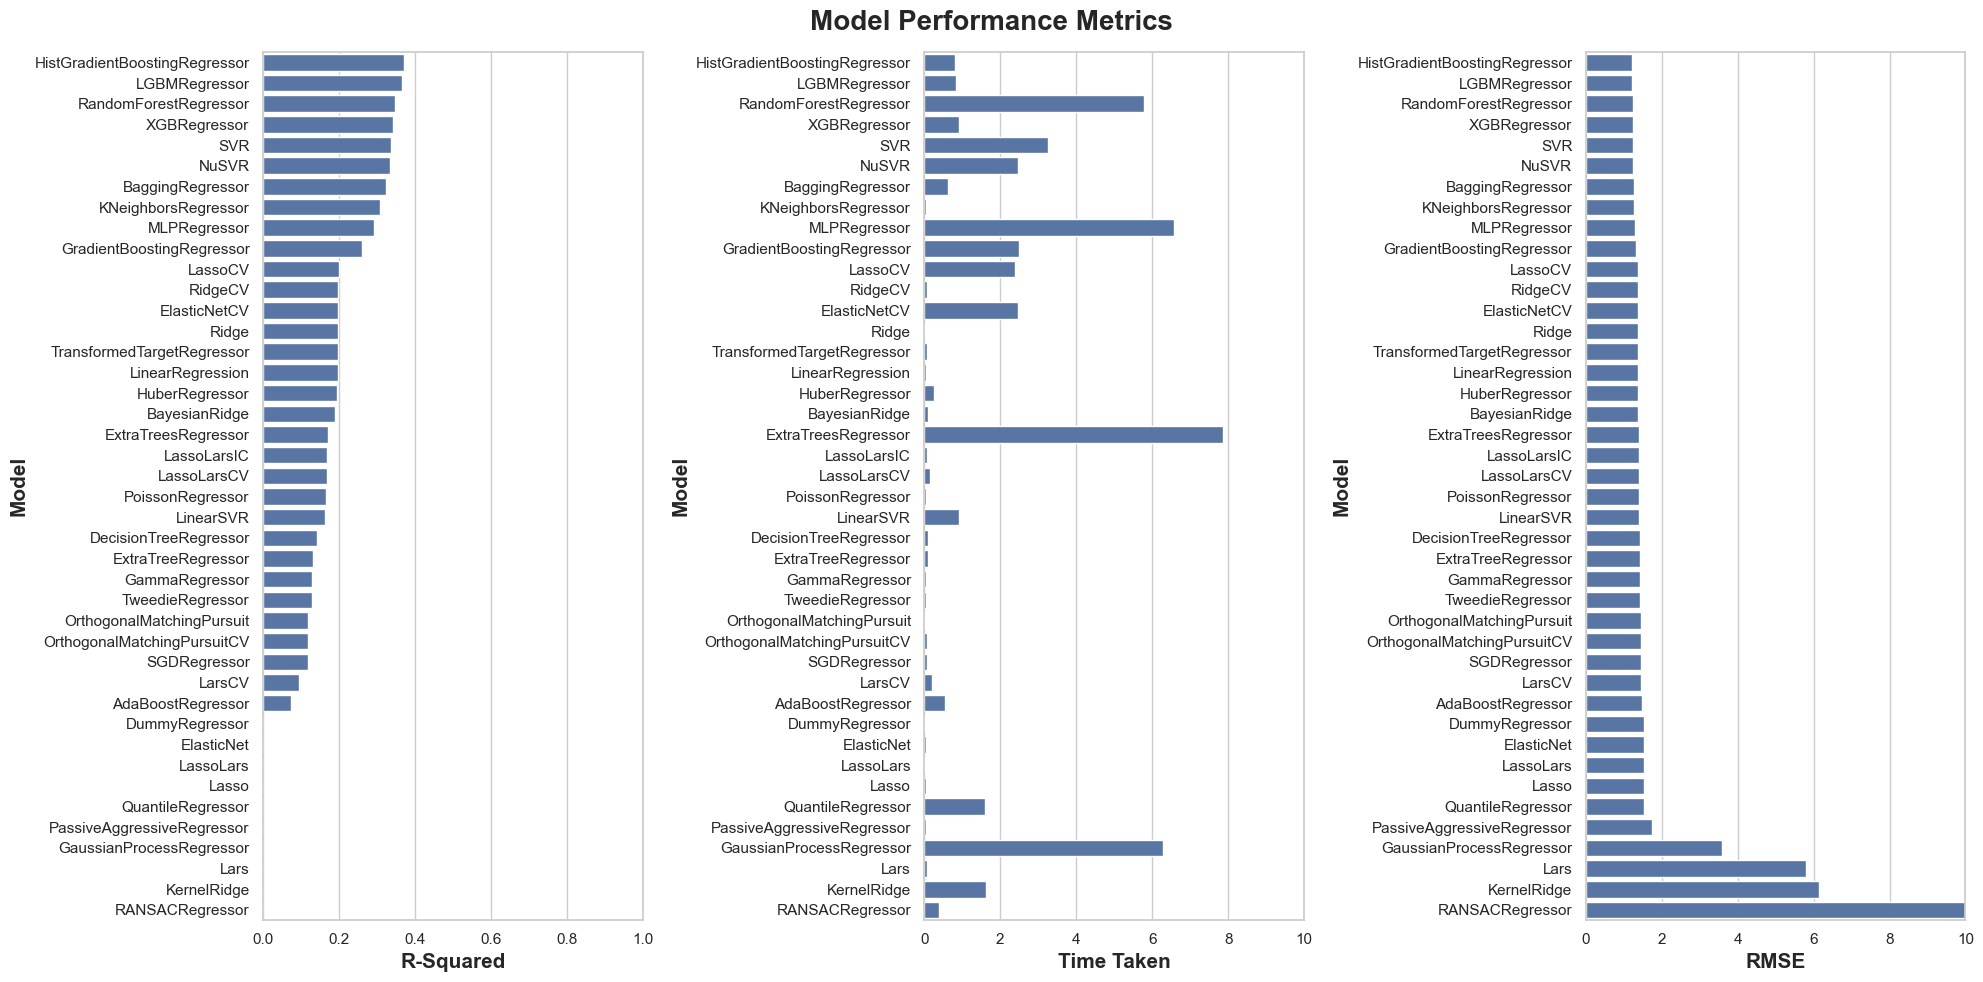

In [131]:
# Visualize the data

# train['R-Squared'] = [0 if i < 0 else i for i in train.iloc[:,0] ]

# print(train['R-Squared'])

sns.set(style="whitegrid")

fig, axs = plt.subplots(1, 3, figsize=(20,10))
fig.suptitle('Model Performance Metrics', fontsize=20, fontweight='bold')


axs[0] = sns.barplot(y=train.index, x="R-Squared", data=train, ax=axs[0])
axs[0].set(xlim=(0,1))
axs[0].set_xlabel("R-Squared", fontsize=15, fontweight='bold')
axs[0].set_ylabel("Model", fontsize=15, fontweight='bold')

axs[1] = sns.barplot(y=train.index, x="Time Taken", data=train, ax=axs[1])
axs[1].set(xlim=(0,10))
axs[1].set_xlabel("Time Taken", fontsize=15, fontweight='bold')
axs[1].set_ylabel("Model", fontsize=15, fontweight='bold')

axs[2] = sns.barplot(y=train.index, x="RMSE", data=train, ax=axs[2])
axs[2].set(xlim=(0,10))
axs[2].set_xlabel("RMSE", fontsize=15, fontweight='bold')
axs[2].set_ylabel("Model", fontsize=15, fontweight='bold')
plt.tight_layout()